# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.212408,True,6.536643
1,0.574675,False,1.027019
2,0.935205,True,5.876967
3,0.338902,True,6.597194
4,-0.580575,False,-0.853339
...,...,...,...
995,0.833749,True,5.393202
996,-0.541168,True,3.493459
997,1.070072,True,5.613771
998,-0.730321,False,-0.608369


<AxesSubplot:xlabel='v0'>

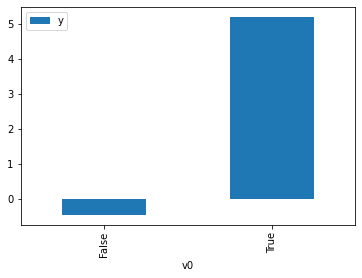

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

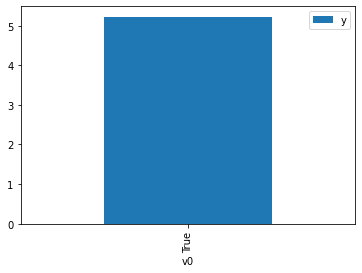

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.328751,False,-0.183292,0.362827,2.756137
1,-1.897793,False,-3.062250,0.987980,1.012166
2,-0.505040,False,-1.440963,0.785645,1.272840
3,-0.147939,False,-0.293244,0.622790,1.605677
4,-1.717888,False,-3.534673,0.982143,1.018181
...,...,...,...,...,...
995,-0.817409,False,-2.240138,0.880423,1.135818
996,-0.665062,False,-1.278563,0.839731,1.190858
997,0.328751,False,-0.183292,0.362827,2.756137
998,-0.754775,False,-0.737387,0.864897,1.156208


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.030322,True,8.359780,0.893769,1.118857
1,0.068297,True,6.863013,0.495370,2.018691
2,0.129471,True,4.958344,0.529489,1.888613
3,-0.911207,True,3.771236,0.099221,10.078470
4,-0.034004,True,2.524764,0.438569,2.280143
...,...,...,...,...,...
995,1.597488,True,8.451245,0.967592,1.033493
996,-0.710274,True,5.515244,0.147143,6.796126
997,0.342769,True,6.352555,0.644379,1.551882
998,1.597488,True,8.451245,0.967592,1.033493


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                          1.035e+04
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        14:24:01   Log-Likelihood:                         -1375.2
No. Observations:                1000   AIC:                                      2754.
Df Residuals:                     998   BIC:                                      2764.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8191      0.032     56.618      0.000       1.756       1.882
x2             5.1496      0.050    103.008      0.000       5.052       5.248
==============================================================================
Omnibus:                        0.954   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.955
Skew:                           0.075   Prob(JB):                        0.620
Kurtosis:                       2.983   Cond. No.                         1.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""